In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import joblib

print("Libraries imported successfully")





Libraries imported successfully


In [26]:
DATA_PATH = "../Data/processed/fused_ppg_acc_features.csv"
df = pd.read_csv(DATA_PATH)

print("Original shape:", df.shape)
df.head()



Original shape: (1158, 23)


,subject_id,activity,hr_bpm,hrv,peak_count,R_ratio,red_ac,ir_ac,ppg_mean,ppg_std,...,ax_std,ay_std,az_std,ax_rms,ay_rms,az_rms,sma,ax_energy,ay_energy,az_energy
0,s12,run,99.709182,0.007644,9,1.580212,98.586438,256.296416,-1.116858,68.371286,...,0.869638,0.956757,1.062938,0.869656,0.957057,1.063297,2.305827,0.756302,0.915958,1.130601
1,s12,run,100.190840,0.011256,8,1.036670,91.672293,219.962447,2.855715,59.774673,...,0.956000,1.232725,1.229593,0.956000,1.233972,1.229737,2.765251,0.913935,1.522688,1.512253
2,s12,run,93.541203,0.036374,8,1.550534,93.461807,202.217577,2.343746,59.500541,...,0.965507,1.294507,1.204765,0.966029,1.294563,1.204810,2.774363,0.933211,1.675892,1.451567
3,s12,run,86.248203,0.019813,7,1.098686,85.358685,185.129674,-2.086325,58.417425,...,0.947062,1.383521,1.382024,0.947252,1.383993,1.383435,2.935472,0.897287,1.915438,1.913892
4,s12,run,85.836910,0.017000,7,-0.962195,73.637724,182.366085,-0.376455,58.327658,...,0.814431,1.360278,1.347730,0.815462,1.360294,1.351097,2.800067,0.664978,1.850399,1.825463


In [27]:
df = df.dropna().reset_index(drop=True)
print("Shape after NaN removal:", df.shape)


Shape after NaN removal: (1158, 23)


In [28]:
selected_features = [
    # ---- PPG features ----
    'peak_count',
    'ppg_mean',
    'ppg_std',
    'ppg_rms',
    'ppg_energy',
    'ppg_entropy',

    # ---- Motion features ----
    'ax_std', 'ay_std', 'az_std',
    'ax_rms', 'ay_rms', 'az_rms',
    'sma',
    'ax_energy', 'ay_energy', 'az_energy'
]

X = df[selected_features]
y = df[['hr_bpm', 'R_ratio']]

print("Input shape:", X.shape)
print("Target shape:", y.shape)




Input shape: (1158, 16)
Target shape: (1158, 2)


In [30]:
subjects = df['subject_id'].unique()
split_idx = int(0.7 * len(subjects))

train_subjects = subjects[:split_idx]
test_subjects = subjects[split_idx:]

train_mask = df['subject_id'].isin(train_subjects)
test_mask = df['subject_id'].isin(test_subjects)

X_train = X[train_mask]
X_test = X[test_mask]

y_train = y[train_mask]
y_test = y[test_mask]

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)



X_train: (578, 16) X_test: (580, 16)
y_train: (578, 2) y_test: (580, 2)


In [31]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


In [146]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(2, activation='linear')   # HR + R_ratio
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.summary()



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 64)                1088      
                                                                 
 dropout_35 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 128)               8320      
                                                                 
 dropout_36 (Dropout)        (None, 128)               0         
                                                                 
 dense_50 (Dense)            (None, 32)                4128      
                                                                 
 dropout_37 (Dropout)        (None, 32)                0         
                                                                 
 dense_51 (Dense)            (None, 2)               

In [147]:
early_stop = EarlyStopping(
    monitor='val_mae',
    patience=35,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stop]
)



Epoch 1/10
15/15 [==============================] - 1s 15ms/step - loss: 0.9589 - mae: 0.5283 - val_loss: 0.2238 - val_mae: 0.2872
Epoch 2/10
15/15 [==============================] - 0s 8ms/step - loss: 0.7326 - mae: 0.3819 - val_loss: 0.2500 - val_mae: 0.3256
Epoch 3/10
15/15 [==============================] - 0s 6ms/step - loss: 0.6825 - mae: 0.3358 - val_loss: 0.2033 - val_mae: 0.2795
Epoch 4/10
15/15 [==============================] - 0s 5ms/step - loss: 0.6999 - mae: 0.3458 - val_loss: 0.2143 - val_mae: 0.3066
Epoch 5/10
15/15 [==============================] - 0s 5ms/step - loss: 0.6974 - mae: 0.3449 - val_loss: 0.2121 - val_mae: 0.2951
Epoch 6/10
15/15 [==============================] - 0s 6ms/step - loss: 0.6893 - mae: 0.3403 - val_loss: 0.2068 - val_mae: 0.3055
Epoch 7/10
15/15 [==============================] - 0s 6ms/step - loss: 0.6699 - mae: 0.3301 - val_loss: 0.2131 - val_mae: 0.3058
Epoch 8/10
15/15 [==============================] - 0s 5ms/step - loss: 0.6929 - mae: 0.3

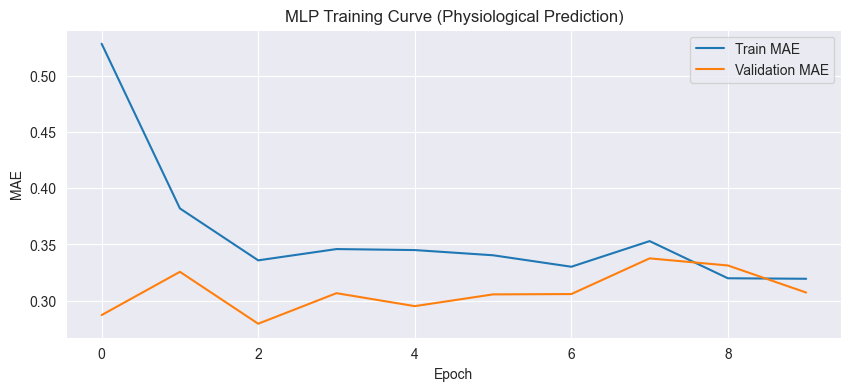

In [148]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MLP Training Curve (Physiological Prediction)')
plt.legend()
plt.show()



In [149]:
#EVALUATION
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mae_hr = mean_absolute_error(
    y_test['hr_bpm'].values,
    y_pred[:, 0]
)

mae_spo2 = mean_absolute_error(
    y_test['R_ratio'].values,
    y_pred[:, 1]
)

print(f"Test MAE (HR): {mae_hr:.2f} bpm")
print(f"Test MAE (SpO₂): {mae_spo2:.4f} R_ratio units")



19/19 [==============================] - 0s 2ms/step
Test MAE (HR): 5.61 bpm
Test MAE (SpO₂): 0.2701 R_ratio units


C:\Users\n\AppData\Local\Temp\ipykernel_11124\1405033046.py:25: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()


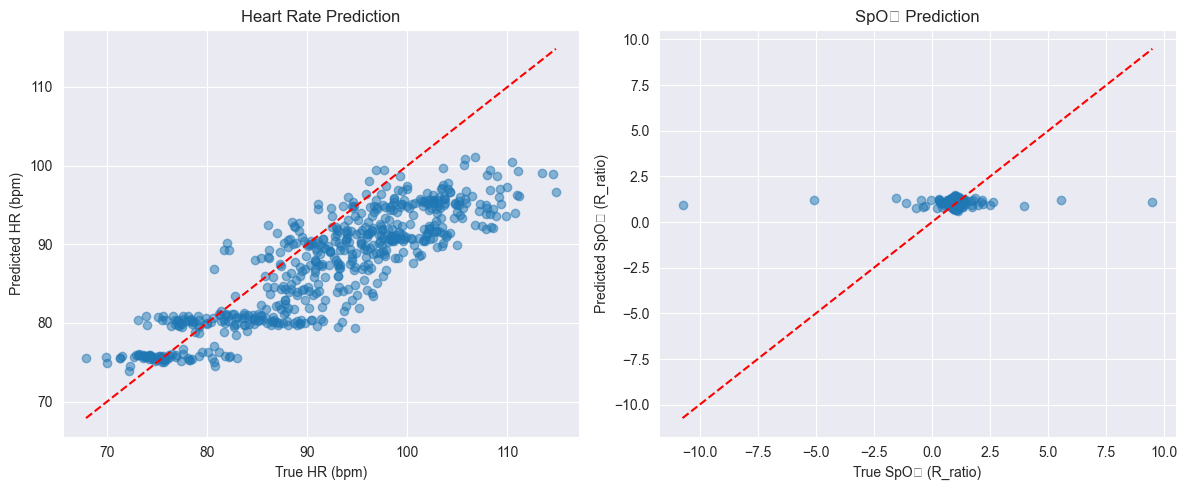

In [151]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test['hr_bpm'], y_pred[:, 0], alpha=0.5)
plt.plot(
    [y_test['hr_bpm'].min(), y_test['hr_bpm'].max()],
    [y_test['hr_bpm'].min(), y_test['hr_bpm'].max()],
    'r--'
)
plt.xlabel("True HR (bpm)")
plt.ylabel("Predicted HR (bpm)")
plt.title("Heart Rate Prediction")

plt.subplot(1, 2, 2)
plt.scatter(y_test['R_ratio'], y_pred[:, 1], alpha=0.5)
plt.plot(
    [y_test['R_ratio'].min(), y_test['R_ratio'].max()],
    [y_test['R_ratio'].min(), y_test['R_ratio'].max()],
    'r--'
)
plt.xlabel("True SpO₂ (R_ratio)")
plt.ylabel("Predicted SpO₂ (R_ratio)")
plt.title("SpO₂ Prediction")

plt.tight_layout()
plt.show()


In [153]:

# Create folder to save models if it doesn't exist


# Save the Keras model
model.save("Deep Learning Module/models/physio_mlp/physio_mlp_tf")

# Save the input and output scalers
joblib.dump(scaler_X, "Deep Learning Module/models/physio_mlp/scaler_X.pkl")
joblib.dump(scaler_y, "Deep Learning Module/models/physio_mlp/scaler_y.pkl")

print("MLP model and scalers saved successfully!")


INFO:tensorflow:Assets written to: Deep Learning Module/models/physio_mlp/physio_mlp_tf\assets


INFO:tensorflow:Assets written to: Deep Learning Module/models/physio_mlp/physio_mlp_tf\assets


MLP model and scalers saved successfully!
